In [1]:
import pandas as pd
from pyvi import ViTokenizer, ViPosTagger
import nltk
import seaborn as sns
from matplotlib import pyplot
import warnings
warnings.simplefilter("ignore")

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten
from tensorflow.keras import layers , activations , models , preprocessing , utils
import tensorflow as tf
from  sklearn.model_selection import train_test_split

from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout

In [3]:
filename= 'train_nor_811.xlsx'
data = pd.read_excel(filename, engine='openpyxl')

In [4]:
data.head()

,Unnamed: 0,Emotion,Sentence
0,188,Other,cho mình xin bài nhạc tên là gì với ạ
1,166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...
3,316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :))
4,1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...


In [5]:
data.drop(columns={'Unnamed: 0'},axis = 1, inplace = True)
data.head()

,Emotion,Sentence
0,Other,cho mình xin bài nhạc tên là gì với ạ
1,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,Disgust,lo học đi . yêu đương lol gì hay lại thích học...
3,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :))
4,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...


In [6]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encodeEmotion = encoder.fit_transform(data.Emotion)
data.Emotion = encodeEmotion
data.head()

,Emotion,Sentence
0,4,cho mình xin bài nhạc tên là gì với ạ
1,1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1,lo học đi . yêu đương lol gì hay lại thích học...
3,2,uớc gì sau này về già vẫn có thể như cụ này :))
4,2,mỗi lần có video của con là cứ coi đi coi lại ...


In [7]:
data.Emotion.value_counts()

2    1558
1    1071
4    1021
5     947
0     391
3     318
6     242
Name: Emotion, dtype: int64

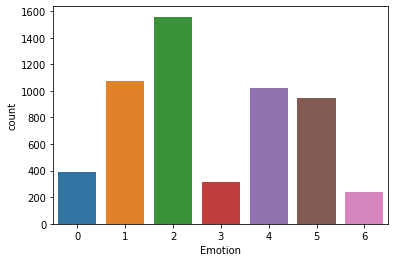

In [8]:
# emotion plot
sns.countplot(data.Emotion)
pyplot.show()

In [9]:
# check for any 'null' comment
no_comment = data[data['Sentence'].isnull()]
len(no_comment)

0

In [10]:
msg_len_lst = []
for i in range(len(data['Sentence'])):
    msg_len_lst.append(len(data['Sentence'][i]))
data.insert(2,'length',msg_len_lst)
data.head()

,Emotion,Sentence,length
0,4,cho mình xin bài nhạc tên là gì với ạ,37
1,1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,58
2,1,lo học đi . yêu đương lol gì hay lại thích học...,55
3,2,uớc gì sau này về già vẫn có thể như cụ này :)),47
4,2,mỗi lần có video của con là cứ coi đi coi lại ...,67


Text(0.5, 0, 'length')

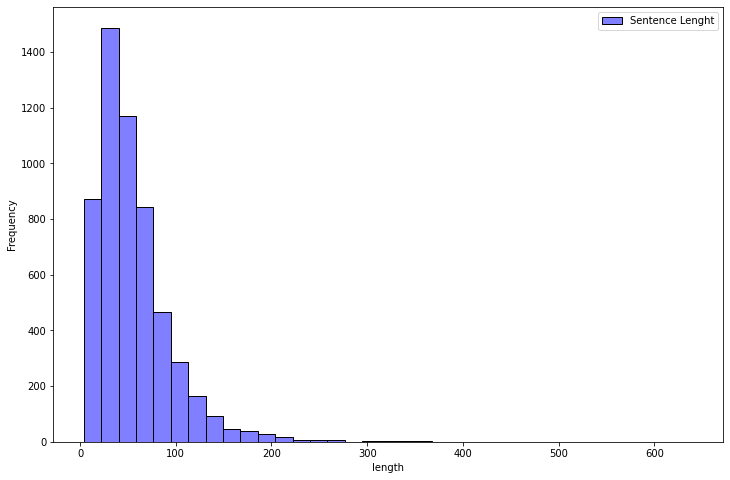

In [11]:
#histogram of sentence length
data["length"].plot(kind = 'hist',bins = 35,edgecolor ='black',color = 'blue',figsize=(12, 8),label = 'Sentence Lenght', fc=(0, 0, 1, 0.5))
pyplot.legend()
pyplot.xlabel('length')

In [12]:
data = data.drop('length', axis = 1)
data.head()

,Emotion,Sentence
0,4,cho mình xin bài nhạc tên là gì với ạ
1,1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1,lo học đi . yêu đương lol gì hay lại thích học...
3,2,uớc gì sau này về già vẫn có thể như cụ này :))
4,2,mỗi lần có video của con là cứ coi đi coi lại ...


In [13]:
sentence=[]
label=[]
for i in range(len(data)):
    sentence.append(ViTokenizer.tokenize(data.Sentence[i]))
    label.append(data.Emotion[i])

In [14]:
import string
def clean_sentences(sentences):
    clean_sent = []
    for sent in sentences:
        temp =[]
        for item in sent:
            item = item.lower()
            if item in string.punctuation:
                continue
            elif(item.isdigit()):
                temp.append("Num")
            else:
                temp.append(item)
        clean_sent.append(' '.join(temp))
    return clean_sent

In [15]:
clean_sent = clean_sentences(nltk.word_tokenize(sent) for sent in sentence)

In [16]:
clean_sent[:10]

['cho mình xin bài nhạc tên là gì với ạ',
 'cho đáng_đời con quỷ về nhà lôi con nhà mày ra mà đánh 😡',
 'lo học đi yêu_đương lol gì hay lại thích học_sinh_học',
 'uớc gì sau_này về già vẫn có_thể như cụ này',
 'mỗi lần có video của con là cứ coi đi coi lại hoài cưng con quá',
 'thằng kia sao mày bắt vợ với bồ tao dọn thế kia nhà mày ở đâu tao đến thịt mày chết',
 'một lí_do trog muôn_vàn lí_do',
 'thật hay đùa ác_vậy không_thể tin được',
 'ko phải con mình mà xem còn thấy đau như vậy huống gì người trong cuộc thật là phẫn_nộ mà cơ_quan_chức_năng làm_việc quá chậm_trễ đến giờ mà vẫn chưa tìm ra người chịu trách_nhiệm 😠 😠 😠 😠 😠 😠',
 'per nghe đi rồi khóc Num trận cho thoải_mái đừng cố gồng mình lên nữa']

# TF-IDF 

In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from tensorflow.keras.callbacks import EarlyStopping


y = data.Emotion
tree_model = DecisionTreeClassifier()

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf = True,max_features=3000)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(clean_sent)
print(tfidf_vectorizer_vectors.shape)

(5548, 3000)


In [94]:
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(tfidf_vectorizer_vectors):
    X_train, X_test = tfidf_vectorizer_vectors[train_index], tfidf_vectorizer_vectors[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    tree_model.fit(X_train, y_train)

In [95]:
y_pred = tree_model.predict(X_test)

In [96]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
TF_IDF = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.18      0.18      0.18        39
           1       0.28      0.29      0.29       101
           2       0.52      0.51      0.52       173
           3       0.34      0.33      0.34        33
           4       0.25      0.26      0.26       101
           5       0.35      0.39      0.37        82
           6       0.29      0.20      0.24        25

    accuracy                           0.36       554
   macro avg       0.32      0.31      0.31       554
weighted avg       0.36      0.36      0.36       554



# LSTM

In [107]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True,split=' ')
tokenizer.fit_on_texts(clean_sent)
print(clean_sent[0])
print(clean_sent[1])
print(clean_sent[2])

X = tokenizer.texts_to_sequences(clean_sent)
print(X[0])
print(X[1])
print(X[2])
X = pad_sequences(X)
print(X[0])
print(X[1])
print(X[2])
print(X.shape)

cho mình xin bài nhạc tên là gì với ạ
cho đáng_đời con quỷ về nhà lôi con nhà mày ra mà đánh 😡
lo học đi yêu_đương lol gì hay lại thích học_sinh_học
[15, 25, 276, 212, 527, 491, 3, 19, 55, 247]
[15, 119, 138, 12, 1015, 80, 49, 2138, 12, 49, 26, 27, 5, 268, 547]
[492, 86, 8, 36, 1016, 217, 19, 50, 22, 116, 86, 204, 86]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  15  25 276 212 527 491   3  19  55 247]
[   0    0    0    0    0    0    0    0    0    0    

In [108]:
print("input shape",X.shape)
vocab_size=len(tokenizer.word_index)+1
print('Vocab count',vocab_size)

input shape (5548, 154)
Vocab count 4236


In [109]:
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [117]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 36)

In [122]:
# X_train.shape()

In [123]:
# HIDDEN_DIM = 200

# model = Sequential()
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=X.shape[1]))
# model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
# model.add(TimeDistributed(Flatten()))

# model.add(LSTM(50, activation ='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(1))

# model.compile(loss='mean_squared_error', optimizer = 'adam')